In [1]:
import os
import sys
sys.path.insert(1, '../../Src/')
import numpy as np
from utils import preprocessing
from models import training
from models import models
from utils import make_report

PATH_DATA          = '../../Data/'
PATH_MODEL         = '../../Results/Models/'
PATH_RESULTS = '../../Results/'


FNMAME             = "stringer_spontaneous.npy"
FEATURES           = "sresp"


THRESHOLDING_FLAG  = False
THRESHOLDING_MAX   = 95  # 95%


NORMALIZATION_FLAG = True
TEST_SIZE          = 0.2

PCA_FLAG           = True



N_SPLITS = 5


np.random.seed(42)

%matplotlib inline
%load_ext autoreload 
%autoreload 2

In [2]:
TARGET = "run"
X,y = preprocessing.get_dataset(PATH_DATA,FNMAME,FEATURES,TARGET)


dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])
 X size : (7018, 11983)
 y size : (7018, 1)


In [3]:
X_train,X_test,y_train,y_test = preprocessing.simple_temporal_splitting(X,y,test_size=TEST_SIZE)

X train :  (5264, 11983) y train : (5264, 1)
X test  :  (1754, 11983) y test  : (1754, 1)


In [4]:
if THRESHOLDING_FLAG:
    X_train,X_test = preprocessing.thresholding(X_train,X_test,thresholing_max=THRESHOLDING_MAX)

if NORMALIZATION_FLAG:
    X_train,X_test = preprocessing.normalization(X_train,X_test)

Normalization process ..
X train : mean [0]= 6.6743774 std [0]= 6.6743774
X test  : mean [0]= 7.5208654 std [0]= 8.151653
Normalization completed!
X train : mean [0]= 1.9628543e-07 std [0]= 1.9628543e-07
X test  : mean [0]= 0.1156612 std [0]= 1.1138103


In [5]:
if PCA_FLAG:
    from sklearn.decomposition import PCA

    #MAX_VARIANCE_EXPLAINED
    #X_train_pca,X_test_pca = preprocessing.auto_PCA(X_train,X_test,max_variance_explanation=None,max_components=20)
    my_model = PCA() #n_components=3000
    my_model.fit_transform(X_train)


(5264,)


Text(0, 0.5, 'explained_variance_ratio_')

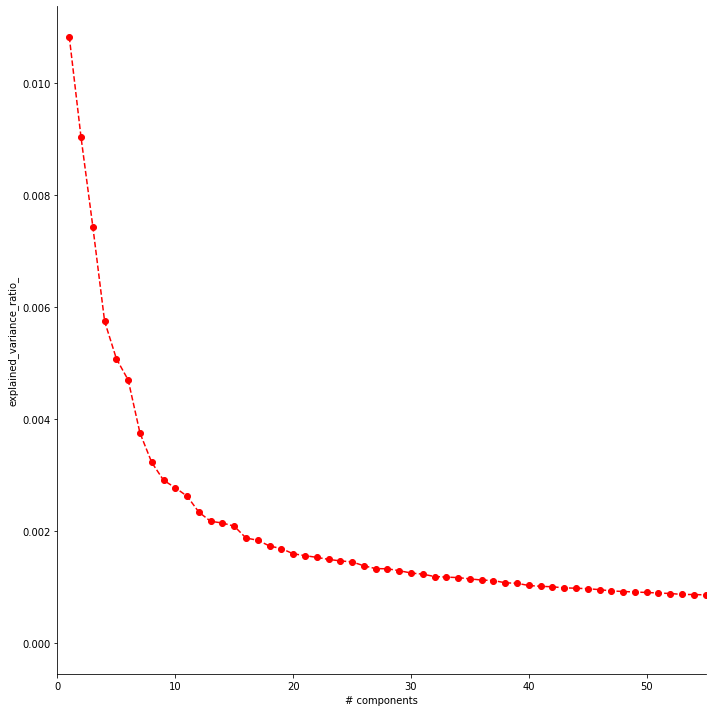

In [6]:
import numpy as np
import matplotlib.pyplot as plt

explained_variance_ratio_ = my_model.explained_variance_ratio_
print(explained_variance_ratio_.shape)
fig = plt.figure(figsize=(10,10))

plt.plot(range(1,len(explained_variance_ratio_)+1),explained_variance_ratio_,'--ro')
plt.xlim(0,55) 
plt.xlabel("# components")
plt.ylabel("explained_variance_ratio_")

In [7]:
X_train_pca = my_model.transform(X_train)[:,:3]
X_test_pca  = my_model.transform(X_test)[:,:3]


metric_train_R2  : 0.566059416799147
metric_train_RMSE: 5.274506331491267
metric_test_R2  : 0.5958471445574866
metric_test_RMSE: 6.595302574845398


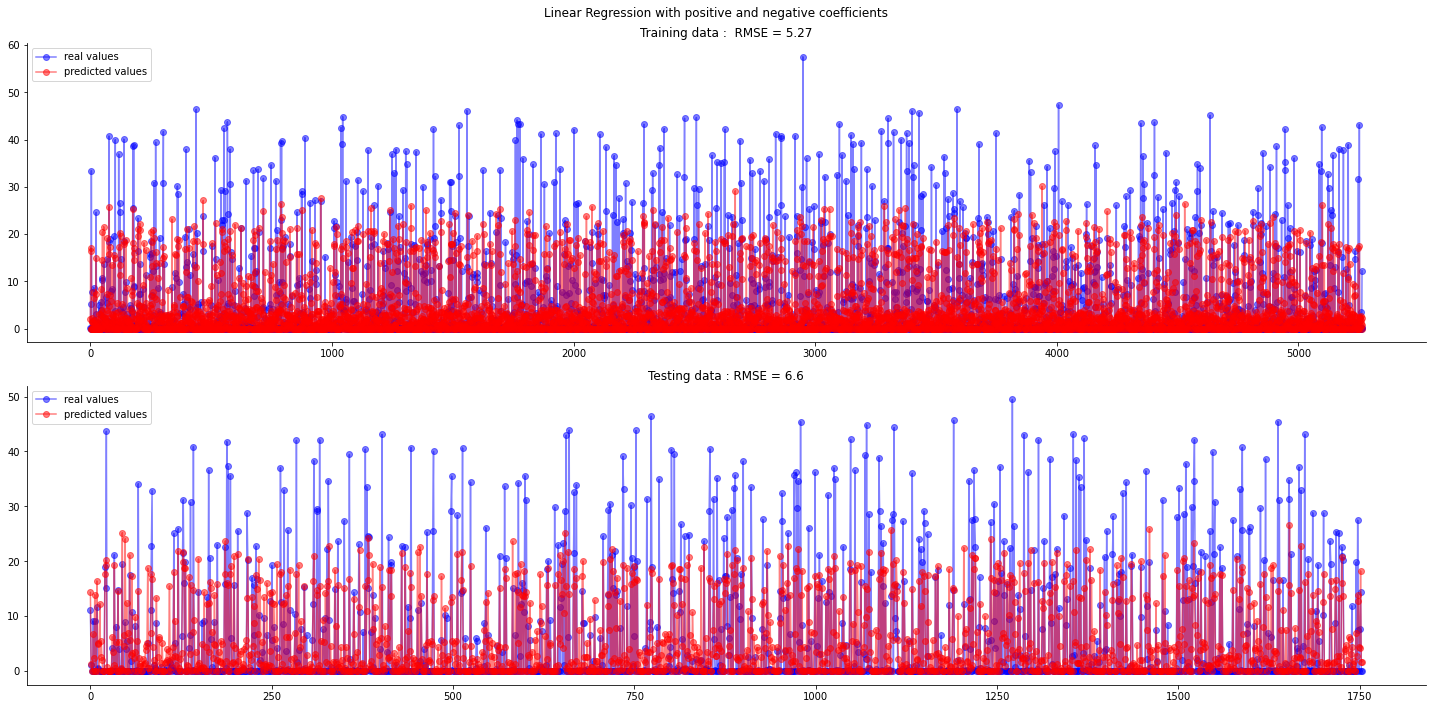

In [8]:


from sklearn.linear_model import LinearRegression

my_model_LR_1 = LinearRegression(positive=False)
#ElasticNet(alpha=0.1,l1_ratio=0.01,random_state=0)
my_model_LR_1.fit(X_train_pca,y_train)


from sklearn.metrics import mean_squared_error


y_train_pred      = my_model_LR_1.predict(X_train_pca) # metric_train_RMSE: 2.4037369030804003e-05


y_train_pred[y_train_pred<=0] = 0  # metric_train_RMSE: 2.196909835364599e-05


metric_train_R2   = my_model_LR_1.score(X_train_pca, y_train)
metric_train_RMSE = mean_squared_error(y_train, y_train_pred, squared=False)

print("metric_train_R2  :",metric_train_R2)
print("metric_train_RMSE:",metric_train_RMSE)

fig = plt.figure(figsize=(20,10))


plt.subplot(2,1,1)
plt.plot(range(len(y_train)),y_train,'-bo',alpha=0.5,label='real values')
plt.plot(range(len(y_train_pred)),y_train_pred,'-ro',alpha=0.5,label='predicted values')

plt.legend(loc="upper left")
plt.title('Training data :  RMSE = '+str(np.round(metric_train_RMSE,2)))
#plt.show()


y_test_pred      = my_model_LR_1.predict(X_test_pca) # metric_test_RMSE: 5.73526388441703

y_test_pred[y_test_pred<=0] = 0 #metric_test_RMSE: 5.5218955408988


metric_test_R2   = my_model_LR_1.score(X_test_pca, y_test)
metric_test_RMSE = mean_squared_error(y_test, y_test_pred, squared=False)

print("metric_test_R2  :",metric_test_R2)
print("metric_test_RMSE:",metric_test_RMSE)

#fig = plt.figure(figsize=(20,5))
plt.subplot(2,1,2)
plt.plot(range(len(y_test)),y_test,'-bo',alpha=0.5,label='real values')
plt.plot(range(len(y_test_pred)),y_test_pred,'-ro',alpha=0.5,label='predicted values')
plt.title('Testing data : RMSE = '+str(np.round(metric_test_RMSE,2)))
plt.legend(loc="upper left")

plt.suptitle('Linear Regression with positive and negative coefficients')
plt.show()


In [9]:
my_model_LR_1.coef_

array([[ 0.4179263 , -0.37469298,  0.01643339]], dtype=float32)

In [10]:

my_model_LR_1.intercept_

array([3.4431539], dtype=float32)